In [11]:
import pandas as pd
content=pd.read_csv('cg_content_based.csv')
collaborative=pd.read_csv('cg_collaborative.csv')
review_df=pd.read_json('../dataset/reviews.jl',lines=True,encoding='utf-8')
game_df_original=pd.read_json('../dataset/games.jl',lines=True,encoding='utf-8')

C:\Users\Praneet\AppData\Local\Temp\ipykernel_25368\3205346132.py:4: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  review_df=pd.read_json('../dataset/reviews.jl',lines=True,encoding='utf-8')


ValueError: Expected object or value

In [ ]:
content=content[['user_id','product_id','recommended']]
collaborative=collaborative[['user_id','product_id','recommended']]

#Merging the datasets to find the common rows between them
merged_df = pd.merge(content, collaborative, on=['user_id', 'product_id','recommended'], how='inner')

In [ ]:
#Randomly rearrgaing the dataset
merged_df=merged_df.sample(merged_df.shape[0], random_state=50)

#Getting 80 percentage of the data as training data
merged_df_train=merged_df.head(int(len(merged_df)*(80/100)))
merged_df_test= merged_df[~merged_df.index.isin(merged_df_train.index)]

In [ ]:
#Pivot table creation for collaborative filtering
user_game_df = pd.pivot_table(merged_df_train,index=['user_id'], columns=['product_id'], values='recommended')

#Finding df_tags for content-based filtering 
game_df = game_df_original[['tags','id']].dropna(subset=['tags', 'id'])
game_df = game_df.assign(genres=game_df['tags'].str.split(', ')).explode('tags')
game_df = game_df[['tags','id']]
one_hot_df = pd.get_dummies(game_df['tags'], prefix='tags')
result_df = pd.concat([game_df['id'], one_hot_df], axis=1)
df_tags = result_df.groupby('id').sum()
df_tags.index = df_tags.index.astype(int)
df_tags.fillna(0, inplace=True)

In [ ]:
def recommendation_colla(user_id):

    # Getting games played by the particular user_id
    random_user_df = user_game_df[user_game_df.index == user_id]
    games_watched = random_user_df.columns[random_user_df.notna().any()].tolist()

    # Restricting columns to only the games played by the particular user
    games_watched_df = user_game_df[games_watched]
    user_game_count = games_watched_df.T.notnull().sum()
    user_game_count = user_game_count.reset_index()
    user_game_count.columns = ["user_id", "game_count"]
    users_same_games = user_game_count[user_game_count["game_count"] > 0]["user_id"]
    final_df = pd.concat([games_watched_df[games_watched_df.index.isin(users_same_games.values)],
                          random_user_df[games_watched]])

    # Finding correlation between users who have played the same games played the particular user
    correlation_df = final_df.T.corr(
        method='kendall').unstack().sort_values().drop_duplicates()
    correlation_df = pd.DataFrame(correlation_df, columns=["corr"])
    correlation_df.index.names = ['user_id_1', 'user_id_2']
    correlation_df = correlation_df.reset_index()

    # Finding positively correlated users
    positive_corr_users = correlation_df[(correlation_df["user_id_1"] == user_id) & (
        correlation_df["corr"] >= 0)][["user_id_2", "corr"]].reset_index(drop=True)
    positive_corr_users = positive_corr_users.sort_values(by='corr', ascending=False)
    positive_corr_users.rename(columns={"user_id_2": "user_id"}, inplace=True)
    positive_corr_users_ratings = positive_corr_users.merge(
        review_df[["user_id", "product_id", "recommended"]], how='inner')
    positive_corr_users_ratings = positive_corr_users_ratings[positive_corr_users_ratings["user_id"] != user_id]
    positive_corr_users_ratings['weighted_rating'] = positive_corr_users_ratings['corr'] * \
        positive_corr_users_ratings['recommended']

    recommendation_df = positive_corr_users_ratings.groupby(
        'product_id').agg({"weighted_rating": "mean"})
    recommendation_df = recommendation_df.reset_index()
    recommendation_df.sort_values(by='weighted_rating', ascending=False).head()
    games_to_be_recommend = recommendation_df[recommendation_df["weighted_rating"] > 0].sort_values(
        "weighted_rating", ascending=False)
    final_game_suggestions = games_to_be_recommend.merge(
        game_df_original[["id", "title"]], left_on='product_id', right_on='id')[['product_id', 'weighted_rating']]
    final_game_suggestions = final_game_suggestions.values.tolist()
    return final_game_suggestions


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def recommendation_content(user_id):

    # Creating a user vector (user profile)
    random_user_vec = merged_df_train[merged_df_train.user_id == user_id][[
        'product_id', 'recommended']]
    random_user_vec.set_index('product_id', inplace=True)
    random_user_vec.fillna(0, inplace=True)
    recommended_game_count = len(random_user_vec[random_user_vec > 0])
    random_user_vec = random_user_vec.squeeze()
    game_tag_pivot = df_tags.mul(random_user_vec, axis=0)
    game_tag_pivot.fillna(0, inplace=True)
    user_profile = game_tag_pivot.sum()/recommended_game_count

    # Finding already played and reviewed games
    played_games = random_user_vec.index

    # Finding similarity between user profile and games (via tags)
    cos_sim = cosine_similarity([user_profile], df_tags)
    cos_sim_df = pd.DataFrame(
        {'cosine_similarity': cos_sim[0], 'ind': df_tags.index})

    # Making sure already playes games are not recommended
    reco_games = cos_sim_df[~(cos_sim_df.ind.isin(played_games))].sort_values(
        by='cosine_similarity', ascending=False)[['ind', 'cosine_similarity']]

    reco_games.set_index('ind', inplace=True)
    final_game_suggestions = game_df_original[game_df_original.id.isin(
        reco_games.index)][['id']]
    final_game_suggestions = final_game_suggestions.merge(
        reco_games, left_on='id', right_on='ind')[['id', 'cosine_similarity']]
    final_game_suggestions = final_game_suggestions.values.tolist()
    return final_game_suggestions


In [ ]:
#Function to calculate hybrid recommendations
def hybrid_weight(colla_list,content_list):
    if(len(colla_list)>0) & (len(content_list)>0):
        df1 = pd.DataFrame(colla_list)
        df1.columns =['product_id','similarity']
        df2 = pd.DataFrame(content_list)
        df2.columns =['product_id','similarity']            
        joined_results= df1.merge(df2, on='product_id',how='inner')
        joined_results['weighted_avg']=(joined_results['similarity_x']*0.2)+(joined_results['similarity_y']*0.8)
        joined_results=joined_results[['product_id','weighted_avg']]
    elif len(colla_list)>0:
        joined_results = pd.DataFrame(colla_list)
        joined_results.columns =['product_id','similarity']
    elif len(content_list)>0:
        joined_results = pd.DataFrame(content_list)
        joined_results.columns =['product_id','similarity']
    else:
        joined_results = pd.DataFrame([])
        joined_results.columns =['product_id','similarity']

    return joined_results.values.tolist()


In [ ]:
#Hybrid ROC Calculation
from collections import defaultdict

def ROC(list_of_users,threshold):
    
    user_predictions = defaultdict(list)
   
    for uid in list_of_users:
        pred=hybrid_weight(recommendation_colla(uid),recommendation_content(uid))
        user_predictions[uid].append(pred)        
    
    om_specificity = dict()
    sensitivity = dict()
    for uid, games in user_predictions.items():      
        
        # Recommended liked games
        reco_l_games = [product_id for product_id, weighted_avg in games[0] if weighted_avg > threshold]
        reco_l_games = set(reco_l_games)     

        #Recommended unliked games
        reco_ul_games = [product_id for product_id, weighted_avg in games[0] if weighted_avg < threshold]
        reco_ul_games=set(reco_ul_games)

        common_games_t = merged_df_test[merged_df_test.user_id==uid]        

        ul_games = common_games_t[common_games_t.recommended == 0]['product_id'].values.tolist()
        ul_games=set(ul_games)
        l_games = common_games_t[common_games_t.recommended == 1]['product_id'].values.tolist()
        l_games=set(l_games)     

        #Confusion matrix calculation
        true_positives = l_games & reco_l_games
        false_negatives = ul_games & reco_ul_games
        false_positives = ul_games & reco_l_games
        true_negatives = l_games & reco_ul_games        

        om_specificity[uid] = len(false_positives) / (len(false_positives) + len(true_negatives)) if (len(false_positives) + len(true_negatives)) != 0 else 0
        sensitivity[uid] = len(true_positives) / (len(true_positives) + len(false_negatives)) if (len(true_positives) + len(false_negatives)) != 0 else 0    

    return sensitivity, om_specificity

In [10]:
#Creating a list of threshold values for ROC_AUC calculation
number_list = []
s = 0
e = 1
number_gap = 0.1
for i in range(int((e-s)/number_gap)+1):
    number_list.append(s + i*number_gap)

#Cumulating list of users common between training and testing data    
list_of_users = list(set(merged_df_train.user_id) & set(merged_df_test.user_id))
list_of_users=[int(i) for i in list_of_users]

NameError: name 'merged_df_train' is not defined

In [ ]:
# Storing user list for testing
pd.DataFrame({'user list': list_of_users}).to_csv("user_list.csv")

In [ ]:
#Sensitivity and 1-Specificity calculation for ROC_AUC calcuation 
x =list()
y =list()
for i in number_list:
    sensitivity, om_specificity = ROC(list_of_users,i)
    print(sum(sens for sens in sensitivity.values()) / len(sensitivity))
    print(sum(oms for oms in om_specificity.values()) / len(om_specificity))
    y.append(sum(sens for sens in sensitivity.values()) / len(sensitivity))
    x.append(sum(oms for oms in om_specificity.values()) / len(om_specificity))

0.9117647058823529
0.6176470588235294
0.9117647058823529
0.611764705882353
0.9088235294117647
0.5757002801120449
0.8719049741108564
0.47843031151854687
0.7789734974760821
0.3448349036584331
0.6257352413061755
0.1803743641978936
0.3576563142739613
0.04819749646739265
0.1019140989729225
0.011519607843137256
0.029411764705882353
0.0
0.029411764705882353
0.0
0.0
0.0


NameError: name 'x' is not defined

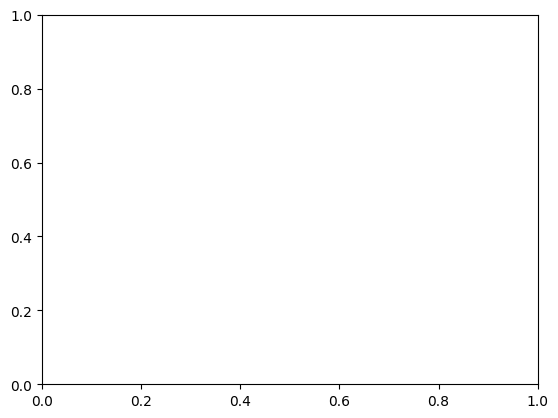

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
fig, ax = plt.subplots()

ax.plot(x, y, color='green')
ax.set_xlabel('1-specificity')
ax.set_ylabel('sensitivity')

plt.savefig('ROC_Hybrid.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
roc_auc = auc(x, y)

# Print the AUC value
print(roc_auc)

NameError: name 'x' is not defined

In [ ]:
#Saving data for final plot
hybrid_df = pd.DataFrame({'x': x, 'y': y})
hybrid_df.to_csv("ROC_hybrid_data.csv")

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import sys

print("--- 1. LOADING INPUTS ---")

try:
    df_content = pd.read_csv('cg_content_based.csv')
    df_collab = pd.read_csv('cg_collaborative.csv')
    print(f"Content Rows: {len(df_content)}")
    print(f"Collaborative Rows: {len(df_collab)}")
except FileNotFoundError as e:
    print(f"Error: {e}. Run previous notebooks first.")
    sys.exit()

# ---------------------------------------------------------
# 2. MERGE
# ---------------------------------------------------------
print("\n--- 2. MERGING SCORES ---")

# Merge on User and Product
merged_df = pd.merge(df_content, df_collab, on=['user_id', 'product_id'], how='inner')

# Handle duplicate 'actual' columns if they exist (actual_x, actual_y)
if 'actual_x' in merged_df.columns:
    merged_df['actual'] = merged_df['actual_x']

print(f"Overlapping Pairs: {len(merged_df)}")

if merged_df.empty:
    print("Error: No overlap between models. Ensure both scripts predicted on the same User-Game pairs.")
    sys.exit()

# ---------------------------------------------------------
# 3. HYBRID SCORE
# ---------------------------------------------------------
print("\n--- 3. CALCULATING HYBRID ---")

def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize scores to 0-1
merged_df['content_norm'] = normalize(merged_df['content_score'])
merged_df['collab_norm'] = normalize(merged_df['collab_score'])

# Weighted Average (0.6 Collab + 0.4 Content)
W_COLLAB = 0.6
W_CONTENT = 0.4
merged_df['hybrid_score'] = (merged_df['collab_norm'] * W_COLLAB) + (merged_df['content_norm'] * W_CONTENT)

# ---------------------------------------------------------
# 4. EVALUATION
# ---------------------------------------------------------
print("\n--- 4. SAVING ROC ---")

if 'actual' in merged_df.columns and len(merged_df['actual'].unique()) > 1:
    fpr, tpr, _ = roc_curve(merged_df['actual'], merged_df['hybrid_score'])
    roc_auc = auc(fpr, tpr)
    print(f"Hybrid AUC: {roc_auc:.4f}")
    
    pd.DataFrame({'x': fpr, 'y': tpr}).to_csv("ROC_hybrid_data.csv", index=False)
    print("Saved 'ROC_hybrid_data.csv'")
else:
    print("Error: Ground truth missing or contains only one class (all 0s or all 1s).")

--- 1. LOADING INPUTS ---
Content Rows: 8909
Collaborative Rows: 178757

--- 2. MERGING SCORES ---
Overlapping Pairs: 8909

--- 3. CALCULATING HYBRID ---

--- 4. SAVING ROC ---
Hybrid AUC: 0.9807
Saved 'ROC_hybrid_data.csv'
